# Catchment Scale Data Analysis

## 1. Preparing the data

In [1]:
## Importing library and setting up
library(stringr)
library(ggplot2)
library(dplyr)

rm(list=ls())


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
#change this to working directory
stew_name = "Baakse Beek Elterweg"
dir = paste("D:/Wageningen/Period 1/EDCA/Part 2/Raw Data/Stuw/", stew_name, sep="")
setwd(dir)

In [3]:
discharge = read.csv('Discharge.csv', skip=16, sep=";")
upstream = read.csv('Upstream.csv', skip=16, sep=";")
downstream = read.csv('Downstream.csv', skip=16, sep=";")
valve = read.csv('Valve.csv', skip=16, sep=";")

Warning message in file(file, "rt"):
"cannot open file 'Upstream.csv': No such file or directory"


ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
#rename columns
colnames(discharge)[1]="Date"
colnames(discharge)[2]="Value"

colnames(upstream)[1]="Date"
colnames(upstream)[2]="Value"

colnames(downstream)[1]="Date"
colnames(downstream)[2]="Value"

colnames(valve)[1]="Date"
colnames(valve)[2]="Value"

print(head(discharge))

In [ ]:
#filtering data
discharge$Value=str_trim(discharge$Value)
discharge$Value[discharge$Value == "---"] <- NA
discharge$Value = as.numeric(gsub(",", ".", gsub("\\.", "", discharge$Value)))

upstream$Value=str_trim(upstream$Value)
upstream$Value[upstream$Value == "---"] <- NA
upstream$Value = as.numeric(gsub(",", ".", gsub("\\.", "", upstream$Value)))

downstream$Value=str_trim(downstream$Value)
downstream$Value[downstream$Value == "---"] <- NA
downstream$Value = as.numeric(gsub(",", ".", gsub("\\.", "", downstream$Value)))

valve$Value=str_trim(valve$Value)
valve$Value[valve$Value == "---"] <- NA
valve$Value = as.numeric(gsub(",", ".", gsub("\\.", "", valve$Value)))

print(head(discharge))

In [ ]:
#changing date format to POSIXlt objects
discharge$Date <- as.POSIXlt(discharge$Date, format="%Y-%m-%d %H:%M:%S")
valve$Date <- as.POSIXlt(valve$Date, format="%Y-%m-%d %H:%M:%S")
upstream$Date <- as.POSIXlt(upstream$Date, format="%Y-%m-%d %H:%M:%S")
downstream$Date <- as.POSIXlt(downstream$Date, format="%Y-%m-%d %H:%M:%S")

In [ ]:
#start and end full data
start_full <- min(discharge$Date[1],upstream$Date[1],valve$Date[1],downstream$Date[1])
end_full <- max(discharge$Date[length(discharge$Date)],upstream$Date[length(upstream$Date)],valve$Date[length(valve$Date)],downstream$Date[length(downstream$Date)])

#make full data
date_sequence <- seq(from = start_full, to = end_full, by = "hour")  
full_data <- data.frame(Date = date_sequence)

full_data <- left_join(full_data, discharge, by = "Date")
colnames(full_data)[2]="Discharge"

full_data <- left_join(full_data, downstream, by = "Date")
colnames(full_data)[3]="Downstream"

full_data <- left_join(full_data, upstream, by = "Date")
colnames(full_data)[4]="Upstream"

full_data <- left_join(full_data, valve, by = "Date")
colnames(full_data)[5]="Valve"

print(head(full_data))

summary(full_data)

## 2. Filling the Data Using Q-h Relationship

In [ ]:
#ommiting NA values and choosing only positive or 0 data
positive_full_data <- full_data[full_data$Upstream-full_data$Valve >= 0,]
positive_full_data <- na.omit(positive_full_data)

print(head(positive_full_data))

In [ ]:
#adding h (water level) column
options(repr.plot.width = 13)

positive_full_data$h = positive_full_data$Upstream-positive_full_data$Valve

print(head(positive_full_data))

In [ ]:
lm_model <- lm(Discharge ~ I(h^(3/2)) - 1, data = positive_full_data)
predicted_values <- predict(lm_model)

discharge_pred <- data.frame(h = seq(0, max(positive_full_data$h), length = 100))

discharge_pred$predicted_discharge <- predict(lm_model, newdata = discharge_pred)

prediction_intervals <- predict(lm_model, newdata = discharge_pred, interval = "prediction")

lower_bound <- prediction_intervals[, "lwr"]
upper_bound <- prediction_intervals[, "upr"]

discharge_pred$lower <- lower_bound
discharge_pred$upper <- upper_bound

head(discharge_pred)

In [ ]:
ggplot(positive_full_data, aes(x = h, y = Discharge)) +
  geom_point(shape = 4, size =3, color = "blue") +
  geom_line(data = discharge_pred, aes(x= h, y = lower), color = "#FFA500", linewidth = 0.5) +
  geom_line(data = discharge_pred, aes(x= h, y = upper), color = "#FFA500", linewidth = 0.5) +
  geom_line(aes(y = predicted_values), color = "red", linewidth = 1) +
  labs(x = "Height (m)", y = expression(paste("Discharge (", m^3,"/h)")))+
  theme(
      panel.background = element_rect(fill = "lightblue"),
      plot.title = element_text(hjust = 0.5, size=16, face ="bold"),
      axis.title.x = element_text(size = 15),               
      axis.title.y = element_text(size = 15),               
      axis.text.x = element_text(size = 12),                
      axis.text.y = element_text(size = 12)  
  ) +
  ggtitle(paste("Q-h Relationship", stew_name))

In [ ]:
summary(lm_model)

In [ ]:
full_data$h = full_data$Upstream - full_data$Valve

filter_data = full_data[is.na(full_data$Discharge) & !is.na(full_data$h),]

a = data.frame(h=filter_data$h)

filter_data$Discharge = predict(lm_model, newdata = a)

NA_before = sum(is.na(full_data$Discharge))

print(paste("NA before: ", NA_before))

fully_data = left_join(full_data, filter_data, by = "Date")

fully_data <- fully_data %>%
  mutate(Discharge.x = ifelse(!is.na(Discharge.y), Discharge.y, Discharge.x)) %>%
  select(-Discharge.y)

fully_data <- fully_data %>%
  select(-Downstream.y)

fully_data <- fully_data %>%
  select(-Upstream.y)

fully_data <- fully_data %>%
  select(-Valve.y)

fully_data <- fully_data %>%
  select(-h.y)

NA_after = sum(is.na(fully_data$Discharge.x))

print(paste("NA after: ", NA_after))

colnames(fully_data)[1]="Date"
colnames(fully_data)[2]="Discharge"
colnames(fully_data)[3]="Downstream"
colnames(fully_data)[4]="Upstream"
colnames(fully_data)[5]="Valve"
colnames(fully_data)[6]="h"

head(fully_data)

In [ ]:
# Specify the file path where you want to save the CSV file
file_name = paste("/", stew_name, "_full data.csv", sep="")
file_path <- paste(dir, file_name, sep="")

# Export the data frame to a CSV file
write.table(fully_data, file = file_path, row.names = FALSE, sep=";")

## 3. Filling Data using ARIMA

In [9]:
library(xts)
o.time.pos <- seq(1:(52*5))
z.idx <- seq.Date(as.Date("2010/1/1"), by="week", length.out = 52*5)
sigma <- 1.15
phi <- 0.8
y_ts <- arima.sim(n = length(o.time.pos), list(ar = c(phi)), sd = sigma)
y.ts <- xts(as.numeric(y_ts), order.by=z.idx)
y.ts.na <- y.ts
# Missing values as NAs
y.ts.na[c(40:45, 72:82)] <- NA
ar1 <- arima(y.ts.na, order=c(2,1,2), method="ML")
y.ts.na1 <- y.ts
# Missing values are deleted from the time series. However, the time 
# index shows that there are weeks missing
y.ts.na1 <- y.ts.na1[-c(40:45, 72:82)]
y.ts.na1

Warning message in arima(y.ts.na, order = c(2, 1, 2), method = "ML"):
"possible convergence problem: optim gave code = 1"


           m.c.seq.row..seq.n...seq.col..drop...FALSE.
2010-01-01                                 -1.45707782
2010-01-08                                 -3.33448283
2010-01-15                                 -2.29069171
2010-01-22                                 -0.40886136
2010-01-29                                 -0.04680107
2010-02-05                                 -1.12459596
2010-02-12                                 -1.77513632
2010-02-19                                 -1.40947481
2010-02-26                                 -0.35705400
2010-03-05                                  0.64460818
       ...                                            
2014-10-17                                 -1.64056328
2014-10-24                                 -0.30037497
2014-10-31                                 -0.98470245
2014-11-07                                  0.24542163
2014-11-14                                  0.96273680
2014-11-21                                  0.49744799
2014-11-28

In [10]:
ar2 <- arima(y.ts.na1, order=c(2,1,2), method="ML")
summary(ar1)

          Length Class  Mode     
coef        4    -none- numeric  
sigma2      1    -none- numeric  
var.coef   16    -none- numeric  
mask        4    -none- logical  
loglik      1    -none- numeric  
aic         1    -none- numeric  
arma        7    -none- numeric  
residuals 260    ts     numeric  
call        4    -none- call     
series      1    -none- character
code        1    -none- numeric  
n.cond      1    -none- numeric  
nobs        1    -none- numeric  
model      10    -none- list     

In [11]:
summary(ar2)

          Length Class  Mode     
coef        4    -none- numeric  
sigma2      1    -none- numeric  
var.coef   16    -none- numeric  
mask        4    -none- logical  
loglik      1    -none- numeric  
aic         1    -none- numeric  
arma        7    -none- numeric  
residuals 243    ts     numeric  
call        4    -none- call     
series      1    -none- character
code        1    -none- numeric  
n.cond      1    -none- numeric  
nobs        1    -none- numeric  
model      10    -none- list     

In [4]:
# Load necessary libraries
library(tseries)
library(forecast)

setwd("D:/Wageningen/Period 1/EDCA/Part 2/Raw Data/Stuw/")
# Read the data from CSV file
data <- read.csv("data.csv")

print(head(data))
ts_data <- ts(data$Discharge, frequency = 1)



  Discharge
1         0
2         0
3         0
4         0
5         0
6         0


Warning message in adf.test(ts_data):
"p-value smaller than printed p-value"


ERROR: Error in xy.coords(x, y, setLab = FALSE): 'x' and 'y' lengths differ


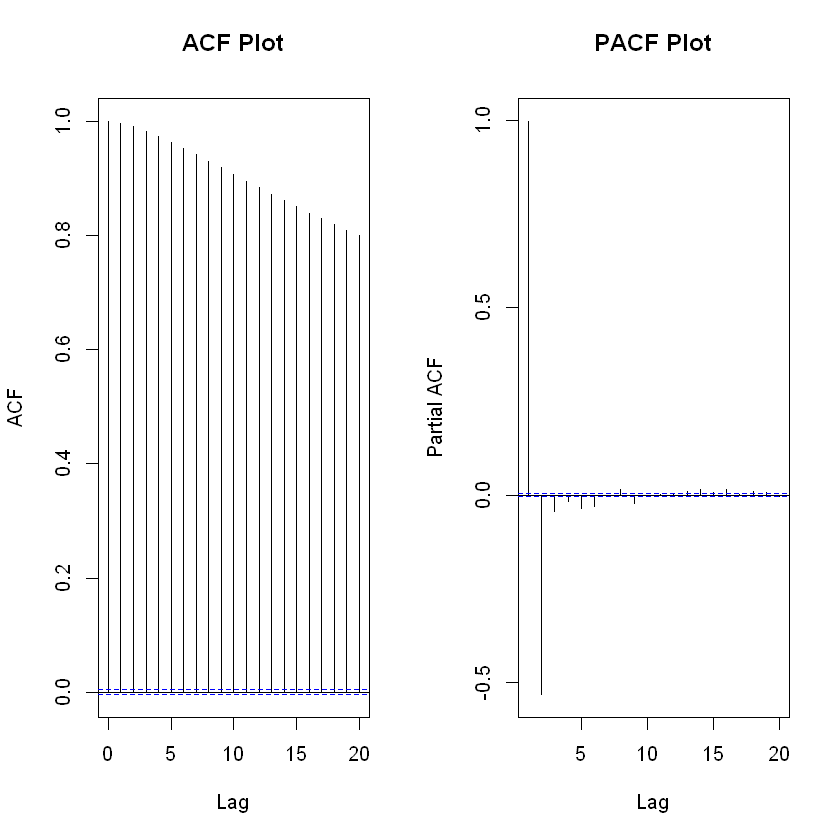

In [8]:

# Check for stationarity using Augmented Dickey-Fuller test
adf_test <- adf.test(ts_data)
#print("ADF Statistic:", adf_test$statistic)
#print("p-value:", adf_test$p.value)

# If the series is not stationary, apply differencing
if (adf_test$p.value > 0.05) {
  ts_diff <- diff(ts_data)
} else {
  ts_diff <- ts_data
}

# Plot ACF and PACF plots to determine ARIMA orders
par(mfrow=c(1,2))
acf(ts_diff, lag.max=20, main="ACF Plot")
pacf(ts_diff, lag.max=20, main="PACF Plot")

# Fit ARIMA model
p <- 1  # Example AR order
d <- 1  # Example differencing order
q <- 1  # Example MA order
arima_model <- arima(ts_diff, order=c(p, d, q))

# Forecast next 30 steps
forecast_steps <- 30
forecast <- forecast(arima_model, h=forecast_steps)

# Plot original series and forecasts
plot(ts_data, xlim=c(1, length(ts_data) + forecast_steps), ylim=c(min(ts_data), max(ts_data, forecast$upper)), 
     xlab="Time", ylab="Value", main="ARIMA Forecast")
lines(forecast$mean, col="red")
polygon(c(time(forecast$mean), rev(time(forecast$mean))), c(forecast$lower, rev(forecast$upper)), col="pink", border=NA, lwd=0)
legend("topright", legend="95% Prediction Interval", fill="pink")


In [ ]:
#start and end period
start = "2000-01-01"
end = "2025-01-01"

In [ ]:
#plotting
options(repr.plot.width = 15)

fully_subset = fully_data[fully_data$Date >= as.POSIXlt(start) & fully_data$Date <= as.POSIXlt(end), ]

#plotting ggplot

plots = list()

labs = list("Date","Discharge", "Downstream (m)", "Upstream (m)", "Valve (m)", "Water level (m)")
for (i in seq(2,6))
{
    p = ggplot(fully_subset, aes(x = as.Date(Date), y = fully_subset[, c(i)])) +
        geom_line(color="blue") +
        labs(y = labs[i], x = "Date") +
        scale_x_date(date_labels = "%b %Y", date_breaks = "12 months") +
        theme(
          panel.background = element_rect(fill = "lightblue"),
          plot.title = element_text(hjust = 0.5, size=16, face ="bold"),
          axis.title.x = element_text(size = 15),               
          axis.title.y = element_text(size = 15),               
          axis.text.x = element_text(size = 12),                
          axis.text.y = element_text(size = 12)  
          ) 
    plots[[i]] = p
}

for (i in 1:length(plots)) {
  print(plots[[i]])
}

print(length(plots))

In [ ]:
hist(log(fully_subset$Discharge))

In [ ]:
discharge_data = fully_subset$Discharge

discharge_data_interpolation = zoo::na.approx(discharge_data)

a = data.frame(discharge_data_interpolation)
b = data.frame(seq(1, nrow(a)))

plot(y=a[,c(1)], x=b[,c(1)], type="l")

dim(a)
dim(fully_subset)

In [ ]:
install.packages("forecast")
library(forecast)

# Sample time series data with missing values
ts_data <- c(1, 2, NA, 4, 5, NA, 7, NA, 9, 10)

# Perform linear interpolation to fill missing values
interpolated_data <- na.approx(ts_data)

# Fit an ARMA model to the interpolated data
arma_model <- Arima(interpolated_data, order = c(p, d, q))

# Print ARMA model summary
print(summary(arma_model))

In [ ]:
install.packages("ncdf4")
install.packages("leaflet")
install.packages("leaflet.extras")

In [ ]:
#load the ncdf4 package 
library(ncdf4)

#open a netCDF file 
nc_file <- nc_open("ESA.nc")
print(nc_file)

In [ ]:
variable_names <- names(ncfile$var)
variable_names


In [ ]:
# Load required libraries
library(ncdf4)
library(leaflet)
library(leaflet.extras)

# Open the NetCDF file
ncfile <- nc_open("ESA1.nc")

# Extract latitude and longitude values from the NetCDF file
lat <- ncvar_get(ncfile, "lat")
lon <- ncvar_get(ncfile, "lon")
time <- ncvar_get(ncfile, "time")


# Extract the variable you want to visualize (e.g., temperature)
temperature <- ncvar_get(ncfile, "sensor")

# Create a data frame for leaflet
data <- data.frame(lat = as.vector(lat), lon = as.vector(lon), time = as.vector(time), temperature = as.vector(temperature))
print(data)
# Create an interactive leaflet map
m <- leaflet(data) %>%
  addTiles() %>%
  addHeatmap(data = data, radius = 15, blur = 10, intensity = data$temperature, max = max(data$temperature))

# Display the map
m


In [ ]:
# Load required libraries
library(forecast)

# Assuming your_time_series_data is your time series data with missing values
# Replace missing values with interpolation or any imputation method
your_time_series_data_no_missing <- na.approx(your_time_series_data)

# Fit ARIMA model using arima() function on the data without missing values
arma_model <- arima(your_time_series_data_no_missing, order = c(p, d, q))

# Plot forecasted values, residuals, and diagnostic plots
par(mfrow = c(3, 1))  # Set up a 3-row layout for the plots

# Plot forecasted values
autoplot(forecast(arma_model))
title("ARMA Model Forecast")

# Plot residuals
autoplot(residuals(arma_model))
title("Residuals")

# Diagnostic plots
checkresiduals(arma_model)


In [ ]:
# Load required libraries
library(forecast)

# Load the AirPassengers dataset (a built-in time series dataset in R)
data(AirPassengers)

# Introduce missing values in the dataset for demonstration purposes
set.seed(42) # Setting seed for reproducibility
AirPassengers_with_missing <- AirPassengers
AirPassengers_with_missing[sample(1:length(AirPassengers), 10)] <- NA

# Replace missing values with interpolation
AirPassengers_no_missing <- na.approx(AirPassengers_with_missing)

# Fit ARIMA model using auto.arima() function on the data without missing values
arma_model <- auto.arima(AirPassengers_no_missing)

# Plot forecasted values, residuals, and diagnostic plots
par(mfrow = c(3, 1))  # Set up a 3-row layout for the plots

# Plot forecasted values
plot.new()  # Initialize a new plot
autoplot(forecast(arma_model))
title("ARIMA Model Forecast")

# Plot residuals
plot.new()  # Initialize a new plot
autoplot(residuals(arma_model))
title("Residuals")

# Diagnostic plots
plot.new()  # Initialize a new plot
checkresiduals(arma_model)


In [ ]:
# Load required libraries
library(forecast)

# Load the AirPassengers dataset (a built-in time series dataset in R)
data(AirPassengers)

# Introduce missing values in the dataset for demonstration purposes
set.seed(42) # Setting seed for reproducibility
AirPassengers_with_missing <- AirPassengers
AirPassengers_with_missing[sample(1:length(AirPassengers), 10)] <- NA

# Replace missing values with interpolation
AirPassengers_no_missing <- na.approx(AirPassengers_with_missing)

# Fit ARIMA model using auto.arima() function on the data without missing values
arma_model <- auto.arima(AirPassengers_no_missing)

# Set up a 3-row layout for the plots
par(mfrow = c(3, 1))

# Plot forecasted values
autoplot(forecast(arma_model))
title("ARIMA Model Forecast")

# Reset graphical parameters to default values
par(mfrow = c(1, 1))


In [ ]:
acf(a)

In [ ]:
# Load required library
library(forecast)

# Create a time series with a trend and some noise
set.seed(123)
ts_data <- ts(cumsum(rnorm(100)), start = 1)

# Fit ARMA(2, 1) model
arma_model <- arima(ts_data, order = c(10, 0, 10))

# Generate forecasts for the next 10 time points
forecast_values <- forecast(arma_model, h = 100)

#forecast_values
# Visualize the original time series and forecasts
plot(ts_data, col = "blue", xlim = c(1, 200), ylim = range(c(ts_data, forecast_values$mean)), xlab = "Time", ylab = "Value", main = "ARMA(2,1) Forecast")
lines(forecast_values$mean, col = "red")
lines(forecast_values$lower, col = "orange", lty = 2)
lines(forecast_values$upper, col = "orange", lty = 2)
legend("topleft", legend = c("Observed", "Forecast", "95% CI"), col = c("blue", "red", "orange"), lty = c(1, 1, 2))
